# Load the dataset

In [1]:
import random
import os
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
#import encoders label and ordinal one
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report
#import pca,lda
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torcheval.metrics as tm

from torch.utils.tensorboard import SummaryWriter


In [2]:
# look for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

Device: cuda


In [3]:
# For reproducibility
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

seed = 42

In [4]:
# Define the Data Layer        
class MyDataset(Dataset):
    def __init__(self, X, y):
        
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
         
        self.num_features = X.shape[1]
        self.num_classes = len(np.unique(y))
       

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [5]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# define a function with different normalization and scaling techniques
def preprocess(X_train, X_val, X_test, y_train, modality, dimR, balancingPolicy, seed=None):
    
    X_train_p, X_val_p, X_test_p, y_train_p = X_train, X_val, X_test, y_train
    
    # Check for balancing policy and apply the technique
    if balancingPolicy == 'over-sampling':
        print('over-sampling applied')
        sm = SMOTE(random_state=seed)
        X_train_p, y_train_p = sm.fit_resample(X_train, y_train)
    elif balancingPolicy == 'under-sampling':
        print('under-sampling applied')
        rus = RandomUnderSampler(random_state=seed)
        X_train_p, y_train_p = rus.fit_resample(X_train, y_train)
    else:
        print('no balancing technique applied')
    
    # Check for modality and apply the normalization technique
    if modality in ['l2', 'l1']:
        print(f'{modality} norm applied')
        X_train_p = preprocessing.normalize(X_train_p, norm=modality)
        X_val_p = preprocessing.normalize(X_val, norm=modality)
        X_test_p = preprocessing.normalize(X_test, norm=modality)
    elif modality in ['standard', 'min-max']:
        print(f'{modality} norm applied')
        if modality == 'standard':
            scaler = preprocessing.StandardScaler()
        elif modality == 'min-max':
            scaler = preprocessing.MinMaxScaler()
        scaler.fit(X_train_p)
        X_train_p = scaler.transform(X_train_p)
        X_val_p = scaler.transform(X_val)
        X_test_p = scaler.transform(X_test)
    else:
        print('no normalization technique applied')
    
    # Apply dimensionality reduction technique
    if dimR in ['pca', 'lda']:
        print(f'{dimR} applied')
        if dimR == 'pca':
            dimR_model = PCA(n_components='mle')
            dimR_model.fit(X_train_p)
        elif dimR == 'lda':
            dimR_model = LinearDiscriminantAnalysis('eigen', n_components=0.95)
            dimR_model.fit(X_train_p, y_train_p)
        X_train_p = dimR_model.transform(X_train_p)
        X_val_p = dimR_model.transform(X_val_p)
        X_test_p = dimR_model.transform(X_test_p)
    else:
        print('no dimensionality reduction technique applied')
        
    print("X train after pp ", X_train_p.shape)
    
    return X_train_p, X_val_p, X_test_p, y_train_p

In [6]:
# Architecture
class FeedForwardPlus(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size, depth=1, batch_norm=False, drop=0):
        super(FeedForwardPlus, self).__init__()
        
        model = []
        model += [nn.Linear(input_size, hidden_size)]
        if batch_norm:
            model += [nn.BatchNorm1d(hidden_size)]
        model += [nn.ReLU()]

        block = [
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        ]

        block_batch_norm = [
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        ]

        block_dropout = [
            nn.Dropout(drop),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        ]

        for i in range(depth):
            if not batch_norm and drop == 0:
                model += block
            elif batch_norm and drop == 0:
                model += block_batch_norm
            elif drop > 0 and not batch_norm:
                model += block_dropout
        
        self.model = nn.Sequential(*model)
        
        self.output = nn.Linear(hidden_size, num_classes)
        

    def forward(self, x):
        h = self.model(x)
        out = self.output(h)
        return out


In [7]:
# Define a function to evaluate the performance on validation and test sets

def test_model(model, data_loader, device):
    model.eval()
    y_pred = []
    y_test = []
    
    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)
        y_pred += model(data)
        #print(y_pred)
        y_test += targets
        #print(targets)
    
    y_test = torch.stack(y_test).squeeze()
    y_pred = torch.stack(y_pred).squeeze()
    y_pred_c = y_pred.argmax(dim=1, keepdim=True).squeeze()
    
    return y_test, y_pred_c, y_pred

In [8]:
# Define a function for the training process
#compute f1 score using torcheval

def train_model(model, criterion, optimizer, epoch, scheduler, train_loader, val_loader, device, writer, log_name="model"):
    n_iter = 0
    best_valid_loss = float('inf')
    for epoch in range(epoch):
        model.train()
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred, targets)
           
            
            # Backward pass
            loss.backward()
            optimizer.step()

            n_iter += 1
        
        labels, _, y_pred = test_model(model, val_loader, device)
        loss_val = criterion(y_pred, labels)
        
        
        f1 = tm.MulticlassF1Score(num_classes=labels.max().item() + 1)
        f1.update(y_pred, labels)
        writer.add_scalar(log_name, f1.compute().item(), epoch)
        
    
        
        # Save best model
        if loss_val.item() < best_valid_loss:
            best_valid_loss = loss_val.item()
            if not os.path.exists('models'):
                os.makedirs('models')
            torch.save(model.state_dict(), 'models/'+log_name)
        
        
        
        (log_name, scheduler.get_last_lr()[0], epoch)
        
        scheduler.step()
            
    return model, best_valid_loss

In [9]:
# look for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

Device: cuda


In [10]:
FILENAME = "train_dataset.csv"
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = LabelEncoder()
y = le.fit_transform(y)

# Separate train, val, and test
indices = np.arange(X.shape[0])
train_idx, temp_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=seed)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.4, stratify=y[temp_idx], random_state=seed)

X_train = X[train_idx, :]
y_train = y[train_idx]
X_val = X[val_idx, :]
y_val = y[val_idx]
X_test = X[test_idx, :]
y_test = y[test_idx]

# Scale data
modality = "standard"
dimR = ""
bp = ""
print("shape of x",X_train.shape)
X_train, X_val, X_test, y_train = preprocess(X_train, X_val, X_test, y_train, modality, dimR=dimR,balancingPolicy=bp)
print("shape of x",X_train.shape)

# Create the dataset
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
test_dataset = MyDataset(X_test, y_test)


(617002, 27)
shape of x (493601, 44)
no balancing technique applied
standard norm applied
no dimensionality reduction technique applied
X train after pp  (493601, 44)
shape of x (493601, 44)


In [11]:
#import class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(4.069593536153022), 1: np.float64(0.338110666630134), 2: np.float64(1.132579964205406), 3: np.float64(4.543873699714628), 4: np.float64(98.7202), 5: np.float64(2.983745390799734), 6: np.float64(1.196724530863599), 7: np.float64(63.855239327296246), 8: np.float64(0.2880440935324428), 9: np.float64(0.9752262219939147)}


# hp tuning

In [13]:
# # # # Grid Search 
import itertools

#hyperparameters
seed = 42
batch_sizes = [256,512]
hidden_sizes = [16,32,64] # 64
batch_norm_list = [False, True]
drop = 0
depths = [2,4,8,16]
num_epochs = 10
learning_rate = 0.01
gammas = [1, 0.5]
step_size = num_epochs / 4

hyperparameters = itertools.product(batch_sizes, hidden_sizes, depths, gammas, batch_norm_list)



# #grid search loop
lowest_loss = float('inf')
best_model_params = None
best_model = None

for batch_size, hidden_size, depth, gamma, batch_norm in hyperparameters:
    fix_random(seed)
    
    start = time.time()

    log_name = "B"+str(batch_size)+"-dim"+str(hidden_size)+"-dp"+str(depth)+"-ep"+str(num_epochs)+"-lr"+str(learning_rate)+"-steplr"+str(step_size)+"-gamma"+str(gamma)+"-BN"+str(batch_norm)+"-drop"+str(drop)
    print(log_name, end=", ")
    
    #start tensorboard
    writer = SummaryWriter('runs/'+log_name)

    # Create relative dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    #define architecture, loss and optimizer
    model = FeedForwardPlus(train_dataset.num_features, train_dataset.num_classes, hidden_size, depth, batch_norm=batch_norm)
    model.to(device)
    
    #train
    criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(list(class_weights.values())).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    model, best_valid_loss = train_model(model, criterion, optimizer, num_epochs, scheduler, train_loader, val_loader, device, writer, log_name)

    writer.add_hparams({'hparam/bsize': batch_size, 'hparam/hidden size': hidden_size, 'hparam/depth':depth+2, 'hparam/scheduler': gamma,'hparam/batch norm': batch_norm}, {'best loss': best_valid_loss})
    writer.flush()

    if best_valid_loss < lowest_loss:
        best_model = model
        lowest_loss = best_valid_loss
        best_model_params = (batch_size, hidden_size, depth, gamma, batch_norm, log_name)

    print("time elapsed:", time.time() - start)
writer.close()

#save the model with the best hyperparameters
import pickle
with open('best_model_params.pkl', 'wb') as f:
    pickle.dump(best_model_params, f)

#save the best model
torch.save(best_model.state_dict(), 'models/best_ffnn_model')


# Load the best model
if best_model_params:
    _, _, _, _, _, best_log_name = best_model_params
    model = FeedForwardPlus(train_dataset.num_features, train_dataset.num_classes, hidden_size, depth, batch_norm=batch_norm)
    
    



B256-dim16-dp2-ep10-lr0.01-steplr2.5-gamma1-BNFalse-drop0, time elapsed: 73.33023381233215
B256-dim16-dp2-ep10-lr0.01-steplr2.5-gamma1-BNTrue-drop0, time elapsed: 85.53294944763184
B256-dim16-dp2-ep10-lr0.01-steplr2.5-gamma0.5-BNFalse-drop0, time elapsed: 73.71055722236633
B256-dim16-dp2-ep10-lr0.01-steplr2.5-gamma0.5-BNTrue-drop0, time elapsed: 82.90476727485657
B256-dim16-dp4-ep10-lr0.01-steplr2.5-gamma1-BNFalse-drop0, time elapsed: 76.97916841506958
B256-dim16-dp4-ep10-lr0.01-steplr2.5-gamma1-BNTrue-drop0, time elapsed: 95.6257963180542
B256-dim16-dp4-ep10-lr0.01-steplr2.5-gamma0.5-BNFalse-drop0, time elapsed: 78.52702069282532
B256-dim16-dp4-ep10-lr0.01-steplr2.5-gamma0.5-BNTrue-drop0, time elapsed: 94.15666055679321
B256-dim16-dp8-ep10-lr0.01-steplr2.5-gamma1-BNFalse-drop0, time elapsed: 93.81874752044678
B256-dim16-dp8-ep10-lr0.01-steplr2.5-gamma1-BNTrue-drop0, time elapsed: 119.94965600967407
B256-dim16-dp8-ep10-lr0.01-steplr2.5-gamma0.5-BNFalse-drop0, time elapsed: 93.405935049

# testing

C:\Users\rinal\AppData\Local\Temp\ipykernel_12780\735848882.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


0.9976904988288879
0.9976904988288879
0.9976904988288879
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1213
           1       1.00      1.00      1.00     14599
           2       1.00      1.00      1.00      4359
           3       0.98      0.99      0.98      1086
           4       0.94      1.00      0.97        50
           5       1.00      0.99      0.99      1654
           6       1.00      0.99      1.00      4124
           7       0.80      1.00      0.89        77
           8       1.00      1.00      1.00     17137
           9       1.00      1.00      1.00      5062

    accuracy                           1.00     49361
   macro avg       0.97      1.00      0.98     49361
weighted avg       1.00      1.00      1.00     49361

balanced accuracy:  0.9963097830054597


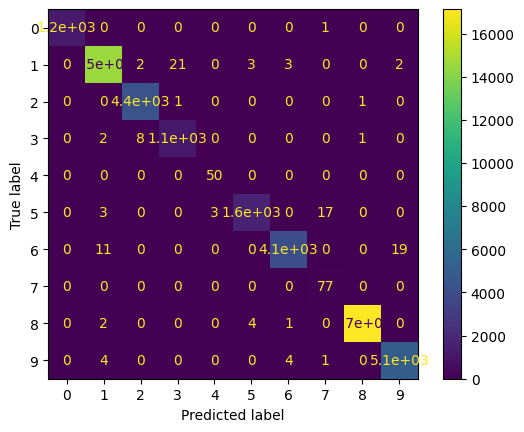

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay,balanced_accuracy_score
test_loader = DataLoader(test_dataset, batch_size=batch_sizes[0])
#print best hp
# print(best_model_params)
# Choose and load the best model and evaluate it on the test set
filename = "models/best_ffnn_model"

hidden_size = 32  # Ensure the hidden size matches the saved model
depth = 2  # Ensure the depth matches the saved model
batch_norm = False  # Ensure batch_norm matches the saved model
model = FeedForwardPlus(train_dataset.num_features, train_dataset.num_classes, hidden_size, depth, batch_norm=batch_norm)
model.load_state_dict(torch.load(filename))
model.to(device)
model.eval()
y_test, y_pred_c, y_pred = test_model(model, test_loader, device)

# print accuracy
print(tm.MulticlassAccuracy().update(y_pred_c, y_test).compute().item())

# print precision
print(tm.MulticlassPrecision(num_classes=y_test.max().item() + 1).update(y_pred, y_test).compute().item())

# Classification report with torcheval
f1 = tm.MulticlassF1Score(num_classes=y_test.max().item() + 1, )
f1.update(y_pred, y_test)
print(f1.compute().item())

#confusion matrix
conf_matrix = tm.MulticlassConfusionMatrix(num_classes=y_test.max().item() + 1)
conf_matrix.update(y_pred_c, y_test)

#use sklearn confusion matrix
ConfusionMatrixDisplay(conf_matrix.compute().cpu().numpy()).plot()

#compute classification report
print(classification_report(y_test.cpu().numpy(), y_pred_c.cpu().numpy()))

#save classification report as txt
with open('ffnn_classification_report.txt', 'w') as f:
    f.write(classification_report(y_test.cpu().numpy(), y_pred_c.cpu().numpy()))

#compute balanced accuracy
print("balanced accuracy: ",balanced_accuracy_score(y_test.cpu().numpy(), y_pred_c.cpu().numpy()))